In [595]:
import geopandas as gpd
from matplotlib import pyplot as plt
import cartopy
import networkx as nx
import networkx.algorithms as algos
from functools import partial
from importlib import reload

import functions
reload(functions)

<module 'functions' from '/Users/hugoschwabe/Documents/Code/bachelor-thesis/functions.py'>

# Initialize and Process Full Graph

In [589]:
G = nx.read_gml("./data/de2025_simp.gml")

nodes = functions.graph_to_nodes_df(G)
nodes["x"] = nodes["coord"].map(lambda x: x[0])
nodes["y"] = nodes["coord"].map(lambda x: x[1])
nodes = gpd.GeoDataFrame(nodes)
nodes = nodes.set_geometry(gpd.points_from_xy(nodes["x"], nodes["y"]), crs="EPSG:3035").to_crs("EPSG:4326")

original = nx.Graph()
original.add_nodes_from(nodes.set_index("nodes").T.to_dict().items())
original.add_edges_from(G.edges(data=True))

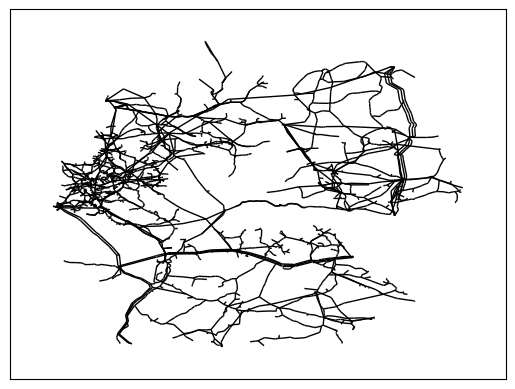

In [590]:
original_pos = {node: (data["coord"]) for node, data in original.nodes(data=True)}
nx.draw_networkx_edges(original, original_pos, arrows=False)

# Initialize NUTS Regions

In [ ]:
nuts3 = gpd.read_file("./data//NUTS3/NUTS_RG_20M_2024_4326.shp").set_index("NUTS_ID")
nuts3 = nuts3[nuts3["LEVL_CODE"] == 3].to_crs("EPSG:4326")
nuts3 = nuts3.reset_index()
nuts3.head(3)

,NUTS_ID,LEVL_CODE,CNTR_CODE,NAME_LATN,NUTS_NAME,MOUNT_TYPE,URBN_TYPE,COAST_TYPE,geometry
0,AL011,3,AL,Dibër,Dibër,NaN,NaN,NaN,"POLYGON ((20.2208 41.86937, 20.56287 41.84614,..."
1,AL012,3,AL,Durrës,Durrës,NaN,NaN,NaN,"POLYGON ((19.55733 41.57767, 19.83218 41.56823..."
2,AL013,3,AL,Kukës,Kukës,NaN,NaN,NaN,"POLYGON ((20.59429 41.87733, 20.56287 41.84614..."


<GeoAxes: >

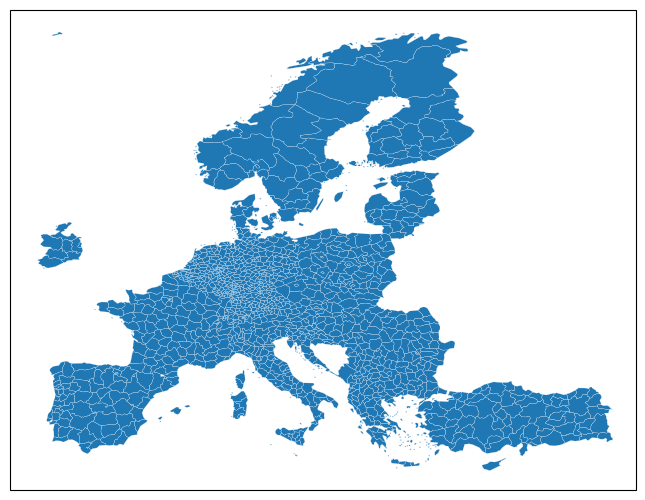

In [232]:
ax = plt.axes(
	[0, 0, 1, 1],
    projection=cartopy.crs.PlateCarree(),
	)

extent = [-13, 47, 33, 73]
ax.set_extent(extent, cartopy.crs.PlateCarree())

nuts3.plot(
	ax=ax,
	edgecolor='white',
	linewidth=0.15,

	)

# Run the Algorithms

In [240]:
from networkx.algorithms.community import greedy_modularity_communities, louvain_communities

# Visualization and Investigation

In [388]:
greedy_modularity_results = functions.run_algo(original, greedy_modularity_communities)

Gefundene Communities: 71
Modularität Q = 0.9595979256171069


In [389]:
greedy_modularity_graph = functions.build_results_graph(original, results=greedy_modularity_results)

In [568]:
functions.score(original, greedy_modularity_graph, nuts3, verbose=True)

nodes_score: 0.008991894630192503
edges_score: 0.01756210283073368
avg_degree_score: 1
complexity: 0.6578153341796913

structure: 0

original regions: 344
simplified regions: 61
regionality: 0.17732558139534885

original properties: 6022.75
simplified properties: 6022.75
properties: 1.0



0.5251285973224038

In [468]:
louvain_results = functions.run_algo(original, partial(louvain_communities, seed=42))

Gefundene Communities: 76
Modularität Q = 0.9598252413510922


In [469]:
louvain_graph = functions.build_results_graph(original, results=louvain_results)

In [569]:
functions.score(original, louvain_graph, nuts3, verbose=True)

nodes_score: 0.009625126646403243
edges_score: 0.018601964182553436
avg_degree_score: 1
complexity: 0.6572576363903477

structure: 0

original regions: 344
simplified regions: 64
regionality: 0.18604651162790697

original properties: 6022.75
simplified properties: 6022.75
properties: 1.0



0.526303236799825

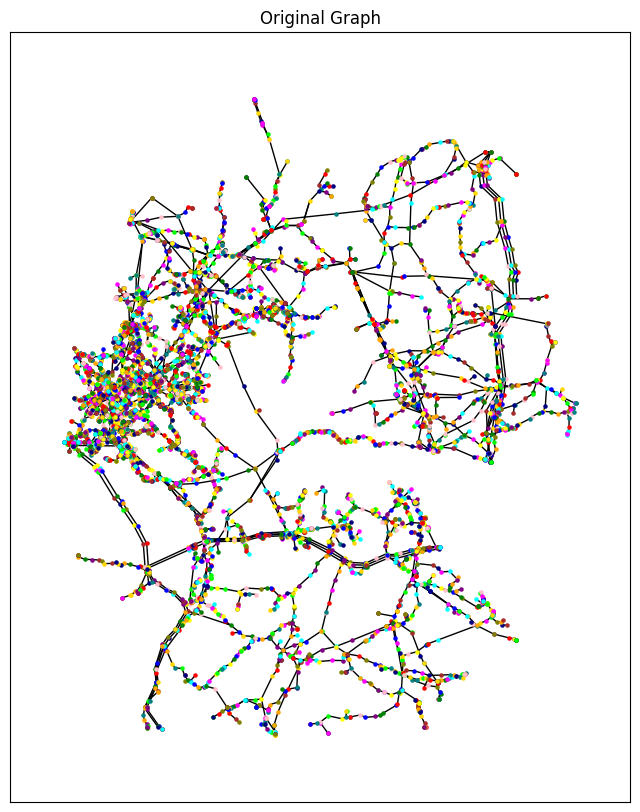

In [ ]:
functions.plot_network(
	graph=original,
	gdf=nuts3,
	node_size=5, 
	title="Original Graph"
)

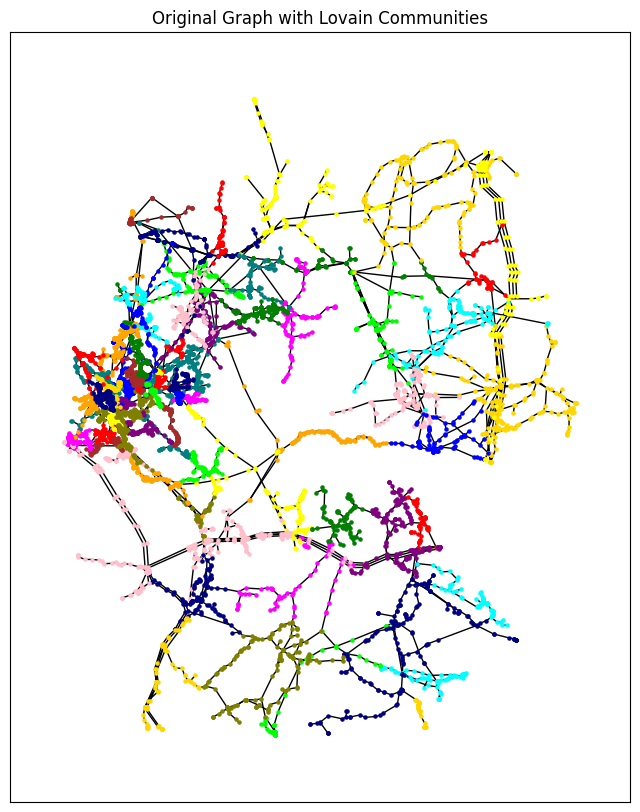

In [ ]:
functions.plot_network(
	graph=original,
	gdf=nuts3,
	clusters=louvain_results,
	node_size=5, 
	title="Original Graph with Lovain Communities"
)

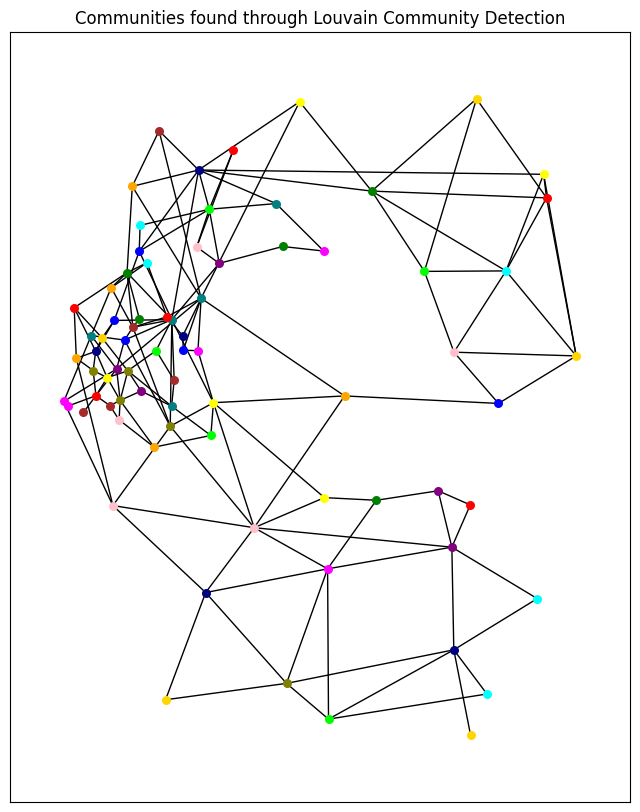

In [ ]:
functions.plot_network(
	graph=louvain_graph,
	gdf=nuts3,
	node_size=30, 
	title="Communities found through Louvain Community Detection"
)

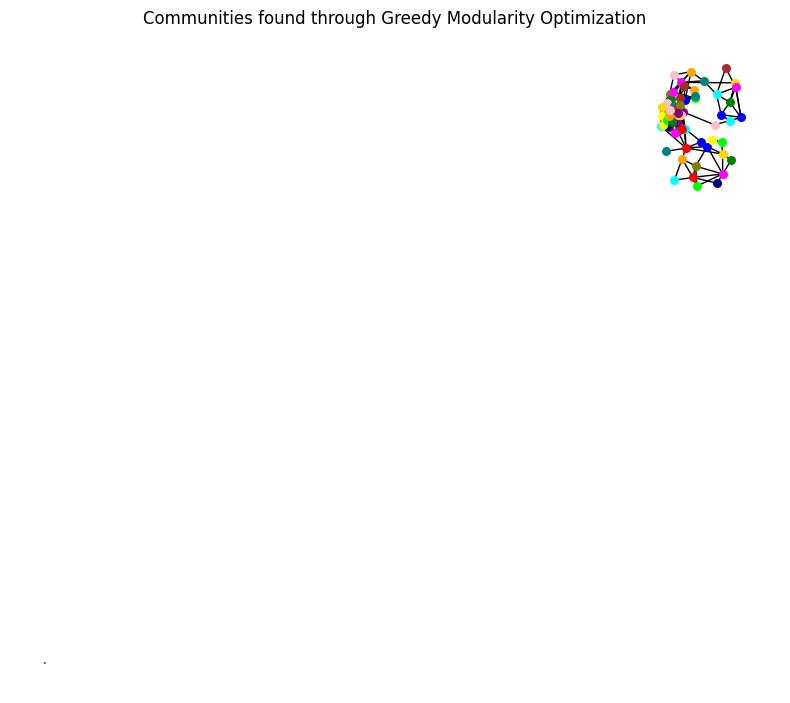

In [594]:
functions.plot_network(
	graph=greedy_modularity_graph,
	gdf=nuts3,
	node_size=30, 
	title="Communities found through Greedy Modularity Optimization"
)

<Axes: >

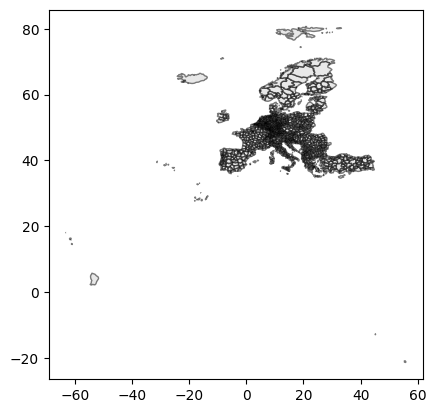

In [573]:
nuts3.plot(ax=plt.gca(), color='lightgrey', edgecolor='black', alpha=0.5)